6章 テキストとシーケンスのためのディープラーニング
=========================================

## 3.リカレントニューラルネットワークの高度な使い方

> 気象データセットのデータの調査

In [1]:
import os

data_dir = '/Users/kunii.sotaro/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


> データの解析

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
print(float_data.shape)

(420551, 14)


> 気温の時系列データのプロット

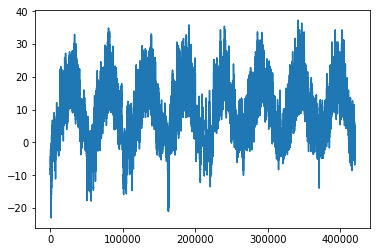

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # 気温(摂氏)
plt.plot(range(len(temp)), temp)

> 最初の10日間の気温データをプロット

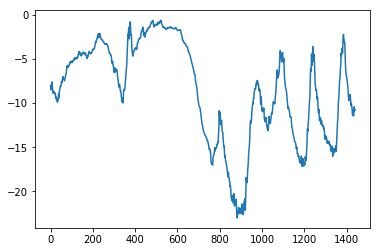

In [6]:
plt.plot(range(1440), temp[:1440])

> データの正規化

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
print(float_data.shape)

(420551, 14)


> 時系列サンプルとそれらの目的値を生成するジェネレータ

* `data`：元の浮動小数点型のデータからなる配列(正規化済み)

* `lookabck`：入力データの時間刻みをいくつ遡るか

* `delay`：目的値の時間刻みをいくつ進めるか

* `min_index`、`max_index`：抽出する時間刻みの上限と下限を表す`data`配列のインデックス(データの一部を検証とテストのために取っておくのに役立つ)

* `shuffle`：サンプルをシャッフルするのか、それとも時間の順序で抽出するのか

* `batch_size`：バッチ1つあたりのサンプルの数

* `step`：データをサンプリングするときの期間(単位は時間刻み)。データ点を1時間ごとに1つ抽出するために6に設定する

In [11]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

> 訓練、検証、テストに使用するジェネレータの準備

In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

> 常識的なアプローチとして、常に、24時間後の気温が現在と同じ気温になると予測し、平均絶対誤差(MAE)を指標として、このアプローチを評価する

In [14]:
# np.mean(np.abs(preds - targets))

> 常識的なベースラインのMAEを計算

In [15]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


> 全結合モデルの訓練と評価

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.
W0917 22:07:29.988155 4589823424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 22:07:30.005104 4589823424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 22:07:30.021842 4589823424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0917 22:07:30.062010 4589823424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0917 22:07:30.161952 4589823424 deprecation_wrapp

Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 1.7158 - val_loss: 0.7507
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.6249 - val_loss: 0.4619
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3217 - val_loss: 0.3298
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2744 - val_loss: 0.3464
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2568 - val_loss: 0.3206
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2446 - val_loss: 0.3262
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2395 - val_loss: 0.3260
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2356 - val_loss: 0.3277
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2285 - val_loss: 0.3477
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2236 - val_lo

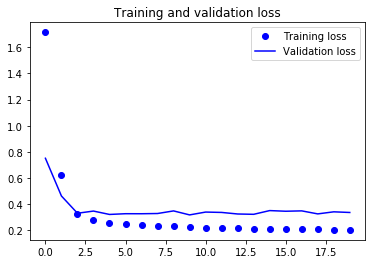

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

> GRUベースのモデルの訓練と評価

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0917 22:11:23.298825 4589823424 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
500/500 [==============================] - 62s 123ms/step - loss: 0.3062 - val_loss: 0.2709
Epoch 2/20
500/500 [==============================] - 61s 121ms/step - loss: 0.2855 - val_loss: 0.2689
Epoch 3/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2783 - val_loss: 0.2661
Epoch 4/20
500/500 [==============================] - 60s 120ms/step - loss: 0.2720 - val_loss: 0.2691
Epoch 5/20
500/500 [==============================] - 62s 125ms/step - loss: 0.2674 - val_loss: 0.2645
Epoch 6/20
500/500 [==============================] - 60s 120ms/step - loss: 0.2642 - val_loss: 0.2657
Epoch 7/20
500/500 [==============================] - 62s 123ms/step - loss: 0.2582 - val_loss: 0.2631
Epoch 8/20
500/500 [==============================] - 62s 123ms/step - loss: 0.2535 - val_loss: 0.2667
Epoch 9/20
500/500 [==============================] - 60s 121ms/step - loss: 0.2504 - val_loss: 0.2695
Epoch 10/20
500/500 [==============================] - 57s 115ms/step - l

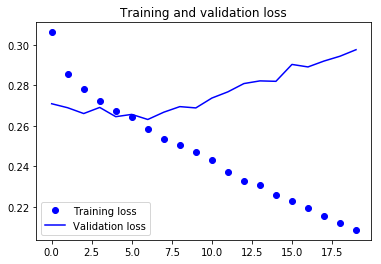

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

> ドロップアウトで正則化されたスタッキングGRUモデルでの訓練と評価

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0917 22:36:45.914191 4589823424 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/40
500/500 [==============================] - 69s 138ms/step - loss: 0.3355 - val_loss: 0.2748
Epoch 2/40
500/500 [==============================] - 69s 138ms/step - loss: 0.3100 - val_loss: 0.2755
Epoch 3/40
500/500 [==============================] - 68s 136ms/step - loss: 0.3085 - val_loss: 0.2725
Epoch 4/40
500/500 [==============================] - 68s 136ms/step - loss: 0.3060 - val_loss: 0.2665
Epoch 5/40
500/500 [==============================] - 68s 136ms/step - loss: 0.3006 - val_loss: 0.2691
Epoch 6/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2971 - val_loss: 0.2677
Epoch 7/40
500/500 [==============================] - 69s 137ms/step - loss: 0.2945 - val_loss: 0.2729
Epoch 8/40
500/500 [==============================] - 67s 134ms/step - loss: 0.2949 - val_loss: 0.2670
Epoch 9/40
500/500 [==============================] - 67s 133ms/step - loss: 0.2916 - val_loss: 0.2674
Epoch 10/40
500/500 [==============================] - 69s 137ms/step - l

KeyboardInterrupt: 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()